In [1]:
import gym
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt
from gym import spaces
from gym.utils import seeding

In [2]:
env = gym.make('Blackjack-v0', natural=True)

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии

In [3]:
STAND = 0
HIT = 1

In [46]:
def policy_simple(state):
  if (state[0] < 19):
    return HIT
  else:
    return STAND  

In [14]:
def get_rewards(policy, env, num_episodes):
  rewards = []
  for i in range(num_episodes):
     done = 0
     observation = env.reset()
     while done == 0:
        observation, reward, done, _ = env.step(policy(observation))
     rewards.append(reward) 
  return rewards
#def calc_rewards_parameters():



In [50]:
num_episodes = 100000
rewards = (get_rewards(policy_simple, env,  num_episodes))


In [51]:
print(f"Средний выигрыш по простой стратегии {np.mean(rewards)}")

Средний выигрыш по простой стратегии -0.19999


(array([    0.,     0., 56215.,     0.,  7594.,     0., 32080.,  4111.]),
 array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 8 Patch objects>)

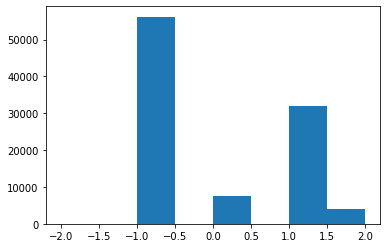

In [8]:
plt.hist(rewards, bins = 8 , range=[-2, 2])

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.
3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [3]:
from collections import defaultdict
class mc_control():
  def __init__(self, env,  eps_decay, eps_min, alpha, gamma, NSTATES, num_episodes):
    self.NSTATES = NSTATES
    self.env = env
    self.eps_decay = eps_decay
    self.eps_min = eps_min
    self.alpha = alpha
    self.gamma = gamma
    #self.Q = {}
    self.eps = 1.0
    self.num_episodes = num_episodes
    
  def get_probs(self,state):
       probs = np.ones(self.NSTATES) * self.eps/NSTATES
       best_action = np.argmax(self.Q[state])
       probs[best_action] = 1 - self.eps + self.eps/NSTATES
       return probs

  def best_policy(self):
    return dict((state,np.argmax(actions)) for state, actions in self.Q.items())

  def create_episode(self):
      stages = []
      state = self.env.reset()
      done = False
      while not done:
        if state in self.Q:
            probs = self.get_probs(state)
            action = np.random.choice(np.arange(self.NSTATES), p=probs)
        else:
            action = self.env.action_space.sample()  
        next_state, reward, done, _ = self.env.step(action)
        stages.append((state, action, reward))
        state = next_state
      
      return stages

  def update_Q(self, episode):
     for state, action, reward in episode:
        first = next(i for i,x in enumerate(episode) if x[0] == state)
        G = sum([x[2] * (gamma ** i) for i,x in enumerate(episode[first : ])])
        self.Q[state][action] = self.Q[state][action] + self.alpha*(G - self.Q[state][action])

  def learn(self):
     self.Q =  defaultdict(lambda: np.zeros(self.NSTATES))
     rewards = []
     result = []
     for i in range(self.num_episodes):
        if (i+1) % 5000 == 0:
            print(result[-1])
        
        self.eps = max(self.eps * self.eps_decay, self.eps_min)
        stages = self.create_episode()
        rewards.append(stages[-1][2])
        result.append(np.mean(rewards))
        self.update_Q(stages)
       
     policy = self.best_policy()
     return policy, self.Q, result



Инициализируем функцию Q. По мере обучения выбираем или исследование или лучшую стратегию на данный момент обучения. Запоминаем все новые переходы в игре. Обновляем стратегию Q

In [39]:
eps_min = 0.01
eps_decay = 0.9
alpha = 0.005
gamma = 1.0
NSTATES = 2

env_base = gym.make('Blackjack-v0')
base = mc_control(env_base,  eps_decay, eps_min, alpha, gamma, NSTATES, 200000)
policy_base, Q_base, result_base = base.learn()

-0.14862972594518903
-0.1323132313231323
-0.1198079871991466
-0.1127556377818891
-0.11308452338093523
-0.10827027567585586
-0.10534586702477214
-0.10400260006500163
-0.10382452943398743
-0.10348206964139282
-0.10242004400080001
-0.10035167252787547
-0.0997553808520131
-0.09960142287746968
-0.09786797157295431
-0.09616370204627558
-0.09374227932093318
-0.09313436815964622
-0.09090622006547437
-0.08938089380893809
-0.0895627577405499
-0.08840989463540577
-0.08804424386299012
-0.08738406153384612
-0.08638469107752862
-0.08572373633643336
-0.08482285053963362
-0.08462203301452154
-0.08372471534286444
-0.08299388662591084
-0.08214246543526087
-0.08203801273757962
-0.081461099764241
-0.08110635944917323
-0.08126903582306184
-0.08008933382963239
-0.07935178027989341
-0.0788214674814078
-0.07844655613618531
-0.07829539147695738


In [41]:
print(f"Обученная политика {policy_base}")

Обученная политика {(17, 10, True): 1, (20, 8, False): 0, (17, 3, False): 0, (19, 10, True): 0, (16, 10, False): 1, (17, 10, False): 0, (16, 5, False): 0, (13, 3, False): 0, (19, 3, False): 0, (9, 2, False): 1, (16, 2, False): 0, (17, 1, False): 0, (20, 4, False): 0, (15, 4, True): 1, (18, 10, False): 0, (20, 6, False): 0, (18, 1, False): 0, (15, 10, True): 1, (15, 6, False): 0, (5, 3, False): 1, (12, 3, False): 1, (16, 3, True): 1, (12, 5, False): 0, (19, 5, False): 0, (15, 8, True): 1, (18, 8, True): 0, (17, 8, True): 1, (16, 8, False): 1, (20, 2, False): 0, (15, 4, False): 0, (13, 10, False): 1, (14, 10, False): 1, (19, 2, False): 0, (13, 1, True): 1, (20, 1, True): 0, (9, 3, False): 1, (13, 1, False): 1, (8, 3, False): 1, (13, 10, True): 1, (16, 4, False): 0, (12, 1, False): 1, (15, 1, False): 0, (9, 7, False): 1, (9, 8, False): 1, (11, 5, False): 1, (13, 8, False): 1, (18, 8, False): 0, (15, 10, False): 1, (20, 10, False): 0, (14, 10, True): 1, (20, 1, False): 0, (16, 1, True): 1,

График изменения средней награды по мере обучения

Text(0.5, 1.0, 'Базовая среда, средняя награда по мере обучения')

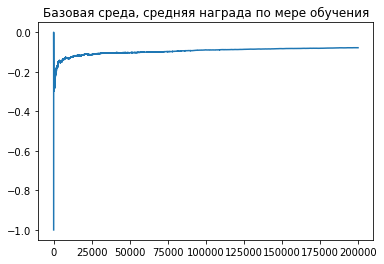

In [45]:
plt.plot( range(200000), result_base)
plt.title("Базовая среда, средняя награда по мере обучения")

Рассчитанная средняя награда по 100000 эпизодам на лучшей обученной политике

In [75]:
def policy_func(state):
  return policy_base[state]

In [77]:
num_episodes = 100000
rewards_base_best = (get_rewards(policy_func, env, num_episodes))


In [78]:
print(f"Средний выигрыш по полученной политике {np.mean(rewards_base_best)}")

Средний выигрыш по полученной политике -0.05626


Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.


In [5]:
def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]



In [65]:
class BlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        #self.sab = sab

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        #print(action)
        assert self.action_space.contains(action)
        if (action == 2):
           done = True
           self.player.append(draw_card(self.np_random))
           if is_bust(self.player):
                done = True
                reward = -2.0
           else: #then dealer starts his step
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
                #if reward < 0:
                #   if is_natural(self.dealer):    
                #      reward = -3
        
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (self.natural   and is_natural(self.player) and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

Запускаем обучение методом Monte Carlo control для окружения с командой double

In [66]:
eps_min = 0.01
eps_decay = 0.9
alpha = 0.01
gamma = 1.0
NSTATES = 3
    
env_double = BlackjackEnv()  
base_double = mc_control(env_double,  eps_decay, eps_min, alpha, gamma, NSTATES, 200000)
policy_double, Q_double, result_double = base_double.learn()

-0.20344068813762753
-0.1931193119311931
-0.19401293419561305
-0.1808590429521476
-0.1765670626825073
-0.16573885796193205
-0.1612046058458813
-0.1550788769719243
-0.15113669192648727
-0.14446288925778517
-0.14143893525336823
-0.13595226587109785
-0.13334051293096816
-0.1302018600265718
-0.12690835877811704
-0.12371404642558032
-0.12098965870186708
-0.11920132445916065
-0.11607490605164265
-0.11488114881148812
-0.11342965171096868
-0.11057373248847717
-0.1093052983069418
-0.10652588771573096
-0.10547284378275026
-0.10351618089369918
-0.10216371973125726
-0.10060071857656126
-0.09831102283464024
-0.09695397969319795
-0.09514254930676973
-0.0942693391833699
-0.09304298813932206
-0.09144759675056913
-0.09066337521928697
-0.08969494274968194
-0.08875183109097887
-0.08831099111047953
-0.0874927563731096
-0.08701543507717538


In [67]:
print(f"Обученная политика c double {policy_double}")

Обученная политика c double {(15, 10, False): 1, (19, 6, False): 0, (15, 1, False): 1, (19, 5, True): 0, (12, 9, False): 1, (12, 10, False): 1, (10, 6, False): 2, (20, 6, False): 0, (16, 1, False): 1, (12, 6, False): 0, (21, 8, True): 0, (20, 10, False): 0, (21, 10, False): 0, (17, 3, True): 1, (20, 3, True): 0, (15, 4, False): 0, (17, 8, False): 0, (20, 5, False): 0, (20, 1, False): 0, (11, 7, False): 2, (18, 3, False): 0, (21, 10, True): 0, (13, 3, False): 0, (21, 2, True): 0, (21, 2, False): 0, (13, 2, False): 0, (20, 5, True): 1, (12, 8, False): 1, (13, 5, False): 0, (14, 10, False): 1, (14, 8, False): 1, (9, 2, False): 1, (19, 10, False): 0, (11, 3, False): 2, (21, 3, True): 0, (18, 9, False): 0, (20, 9, False): 0, (20, 7, False): 0, (16, 3, False): 0, (17, 10, False): 0, (6, 5, False): 1, (14, 5, False): 0, (7, 8, False): 1, (16, 10, False): 0, (6, 7, False): 1, (14, 7, False): 1, (17, 4, True): 2, (19, 8, False): 0, (20, 9, True): 0, (10, 3, False): 2, (16, 8, False): 1, (21, 6,

Text(0.5, 1.0, 'Cреда c double, средняя награда по мере обучения')

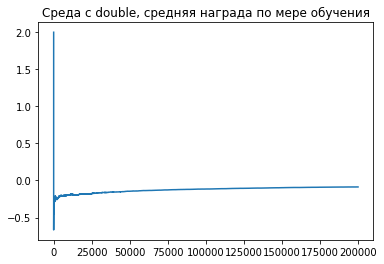

In [68]:
plt.plot( range(200000), result_double)
plt.title("Cреда c double, средняя награда по мере обучения")

In [69]:
def policy_func_double(state):
  return policy_double[state]

In [72]:
num_episodes = 100000
rewards_double_best = (get_rewards(policy_func_double, env_double,  num_episodes))


In [74]:
print(f"Средний выигрыш по в полученной стратегии  {np.mean(rewards_double_best)}")

Средний выигрыш по в полученной стратегии  -0.05027


Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [2]:
import random
class BlackjackEnvCountCards(gym.Env):
    def __init__(self, natural=False):
        self.cards_out_sum = 0
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2), spaces.Discrete(41))
        )
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        self.deck = []
        self.reset_deck()
        self.dealer = []
        self.player = []
                          #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]        
        self.card_values =[-1, 1, 1, 1, 1, 1, 0, 0, 0, -1 ]
        

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_deсk_status(self):
        return (self.cards_out_sum + 20)     

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.get_deсk_status())
    
        
    def reset_deck(self):        
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        random.shuffle(self.deck)
        self.cards_out_sum = 0
        


    def new_game(self):
        self.dealer = []
        self.dealer.append(self.draw_card())
        self.dealer.append(self.draw_card(False))
        self.player = []
        self.player.append(self.draw_card())
        self.player.append(self.draw_card())
        return self._get_obs()

    def draw_card(self, is_shown = True):
        card = self.deck.pop()
        if is_shown:
            self.cards_out_sum += self.get_value(card)
        if len(self.deck) < 15:
            self.reset_deck()
        return card   

    def step(self, action):
        assert self.action_space.contains(action)
        if (action == 2):
           done = True
           self.player.append(self.draw_card())
           if is_bust(self.player):
                done = True
                reward = -2.0
           else: #then dealer starts his step
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(False))
                reward = 2 * cmp(score(self.player), score(self.dealer))
                #if reward < 0:
                #   if is_natural(self.dealer):    
                #      reward = -3
        
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(False))
            reward = cmp(score(self.player), score(self.dealer))
            if is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (self.natural   and is_natural(self.player) and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def get_value(self, card):
        return self.card_values[card - 1]

    def reset(self):
        return self.new_game()

Обучим методом Monte Carlo политику для среду с подсчетом карт.

In [9]:
eps_min = 0.01
eps_decay = 0.99
alpha = 0.01
gamma = 1.0
NSTATES = 3
env_count = BlackjackEnvCountCards()    
base_count = mc_control(env_count,  eps_decay, eps_min, alpha, gamma, NSTATES, 300000)
policy_count, Q_count, result_count = base_count.learn()

-0.33326665333066613
-0.28432843284328435
-0.25561704113607575
-0.24726236311815591
-0.23180927237089483
-0.22150738357945265
-0.21769193405525872
-0.20728018200455012
-0.2038045289895331
-0.19886397727954558
-0.19723994981726942
-0.1935032250537509
-0.1925106540100617
-0.18875983942627753
-0.18526913692182562
-0.1812147651845648
-0.17836680431534488
-0.17692418804653384
-0.17526500278950305
-0.17262172621726218
-0.17002066686349393
-0.16937426703879127
-0.16695797354759606
-0.16445970383086525
-0.1641293130345043
-0.16267817444749574
-0.16256416714197883
-0.16210830077357696
-0.1614011131111249
-0.1603344022293482
-0.15974296608365215
-0.15895099344370903
-0.15883126564403421
-0.15805975329266642
-0.15662946645409404
-0.15518975105417251
-0.15407650852166768
-0.15365344028126462
-0.1524674485510182
-0.15197075985379926
-0.15031292835574808
-0.14983404682879442
-0.1492099963255643
-0.14882340374274428
-0.14854288241281072
-0.14778759907651773
-0.14691126345218491
-0.14662977762407342
-

In [10]:
print(f"Обученная политика c подсчетом карт {policy_count}")

Обученная политика c подсчетом карт {(7, 1, False, 21): 0, (13, 6, True, 22): 1, (15, 10, False, 21): 0, (21, 10, False, 22): 0, (16, 10, False, 21): 0, (20, 4, False, 19): 0, (13, 10, False, 18): 1, (11, 8, False, 19): 1, (13, 8, False, 20): 2, (18, 8, False, 21): 0, (20, 8, False, 22): 0, (14, 5, False, 20): 0, (14, 5, False, 22): 1, (19, 10, False, 20): 0, (14, 10, True, 19): 1, (18, 10, True, 20): 2, (18, 10, True, 17): 1, (16, 10, False, 17): 1, (12, 6, False, 18): 0, (14, 1, False, 17): 0, (21, 1, False, 17): 0, (5, 6, False, 23): 1, (20, 10, False, 20): 0, (14, 10, False, 19): 0, (17, 9, False, 19): 1, (19, 5, True, 20): 0, (17, 5, False, 19): 0, (16, 7, False, 20): 1, (20, 9, False, 18): 0, (17, 6, True, 19): 2, (9, 10, False, 19): 1, (17, 10, False, 19): 0, (18, 10, False, 18): 0, (17, 10, False, 16): 0, (13, 2, True, 16): 1, (18, 8, False, 19): 0, (14, 1, False, 18): 0, (13, 1, False, 19): 1, (12, 6, False, 20): 0, (9, 10, False, 22): 2, (19, 10, False, 21): 0, (19, 1, False,

Text(0.5, 1.0, 'Cреда c double, средняя награда по мере обучения')

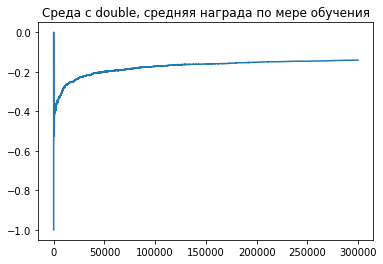

In [11]:
plt.plot( range(300000), result_count)
plt.title("Cреда c подсчетом колоды, средняя награда по мере обучения")

In [12]:
def policy_func_count(state):
  return policy_count[state]

In [ ]:
# num_episodes = 100000
# rewards_count_best = (get_rewards(policy_func_count, env_count, num_episodes))


In [ ]:
#print(f"Средний выигрыш по простой стратегии {np.mean(rewards_count_best)}")

При добавлении подсчета колоды методом плюс минус, количество состояний возросло, Показатели награды стали ниже видимо из-за того, чтобы процесс не совсем сошелся.